In [57]:
import faiss
import numpy as np
import time
#import faiss.contrib.torch_utils
import torch
import pandas as pd 

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

df = pd.read_pickle('DATA/Dataset/wikiart_full_combined_try.pkl')
unique_values = df['artist_name'].explode().unique()
df['influenced_by'] = df['influenced_by'].apply(lambda x: [i for i in x if i in unique_values])
df = df[df['influenced_by'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
feature = 'image_features'

tensors = torch.stack(df[feature].tolist()).to(device)
tensor_dim = tensors.shape[1]
nb_tensors = tensors.shape[0]
k = 11

query_tensors = tensors.cpu().numpy()
nlist = 100  # adjust based on experimentation
quantizer = faiss.IndexFlatL2(tensor_dim)
index = faiss.IndexIVFFlat(quantizer, tensor_dim, nlist)
#index = faiss.index_cpu_to_all_gpus(index)  # If you're using multiple GPUs
index.train(tensors.cpu().numpy())
index.add(tensors.cpu().numpy())



# Perform search
start_time = time.time()
D, I = index.search(query_tensors, k)
end_time = time.time()
print("Standard search time: {:.4f} seconds".format(end_time - start_time))

df['index_vector_similarity'] = I.tolist()

Standard search time: 0.5564 seconds


In [80]:
df['index_vector_similarity']

0        [0, 21137, 35722, 36532, 21176, 20903, 20901, ...
1        [1, 5935, 31648, 29538, 5999, 29561, 30334, 27...
2        [2, 30014, 29691, 21316, 17541, 3623, 23847, 2...
3        [3, 29711, 29662, 29743, 13617, 13604, 13632, ...
4        [4, 29717, 9221, 30131, 25833, 31625, 34261, 1...
                               ...                        
40333    [40333, 5461, 40111, 38214, 40109, 3329, 11135...
40334    [40334, 5797, 5216, 40107, 11143, 5329, 40102,...
40335    [40335, 5756, 40124, 5797, 11078, 5401, 5330, ...
40336    [40336, 11670, 11564, 11454, 11695, 15837, 112...
40337    [40337, 11279, 11558, 5818, 11565, 11287, 1133...
Name: index_vector_similarity, Length: 40338, dtype: object

In [34]:
def get_dictionaries(df,num_examples):
    dict_influenced_by = df.groupby('artist_name')['influenced_by'].first().to_dict()
    artist_to_paintings = {}
    for index, row in df.iterrows():
        artist = row['artist_name']
        artist_to_paintings.setdefault(artist, []).append(index)
    artist_to_influencer_paintings = {artist: [painting for influencer in influencers if influencer in artist_to_paintings for painting in artist_to_paintings[influencer]] for artist, influencers in dict_influenced_by.items()}
    keys_min_val = [key for key, value in artist_to_influencer_paintings.items() if isinstance(value, list) and len(value) > num_examples]
    artist_to_influencer_paintings = {key: value for key, value in artist_to_influencer_paintings.items() if key in keys_min_val}
    artisit_no_influencers = [k for k, v in artist_to_influencer_paintings.items() if len(v) == 0]
    artist_to_influencer_paintings = {key: value for key, value in artist_to_influencer_paintings.items() if key not in artisit_no_influencers}
    return artist_to_influencer_paintings
artist_to_influencer_paintings = get_dictionaries(df, 10)   

In [77]:
list_of_counts = []
for i in df['index_vector_similarity']:
    artist_influenced = df.loc[i[0],'artist_name']
    influencers_paintings = artist_to_influencer_paintings[artist_influenced]
    #print(f'artist: {artist_influenced} has been influenced by {influencers_paintings}')
    count = 0    
    for j in i:
        if j in influencers_paintings:
            if j != i[0]:
                count += 1
                print(f'for index {i[0]}: {j}')
    #print(f'count: {count}')            
    list_of_counts.append(count)
print(np.mean(list_of_counts))

for index 9: 26132
for index 11: 30712
for index 42: 16769
for index 44: 12758
for index 46: 2518
for index 46: 1512
for index 47: 31025
for index 47: 33647
for index 48: 31353
for index 49: 33688
for index 49: 33728
for index 49: 33631
for index 51: 34102
for index 51: 32458
for index 53: 31230
for index 54: 31265
for index 54: 31337
for index 55: 31132
for index 55: 31302
for index 55: 31066
for index 55: 31310
for index 55: 31279
for index 56: 31298
for index 56: 31286
for index 56: 31280
for index 56: 31304
for index 56: 31293
for index 57: 31645
for index 57: 31415
for index 59: 27555
for index 59: 28029
for index 59: 27601
for index 61: 30536
for index 61: 30542
for index 61: 27553
for index 64: 26230
for index 64: 14811
for index 65: 25182
for index 69: 70
for index 70: 69
for index 72: 39285
for index 73: 34167
for index 74: 3454
for index 78: 30573
for index 88: 3109
for index 96: 21157
for index 98: 14045
for index 114: 11249
for index 132: 19736
for index 141: 9640
for index

In [76]:
np.mean(list_of_counts)

0.3066091526600228

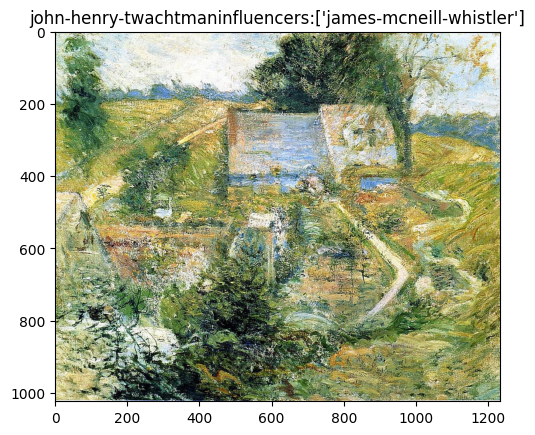

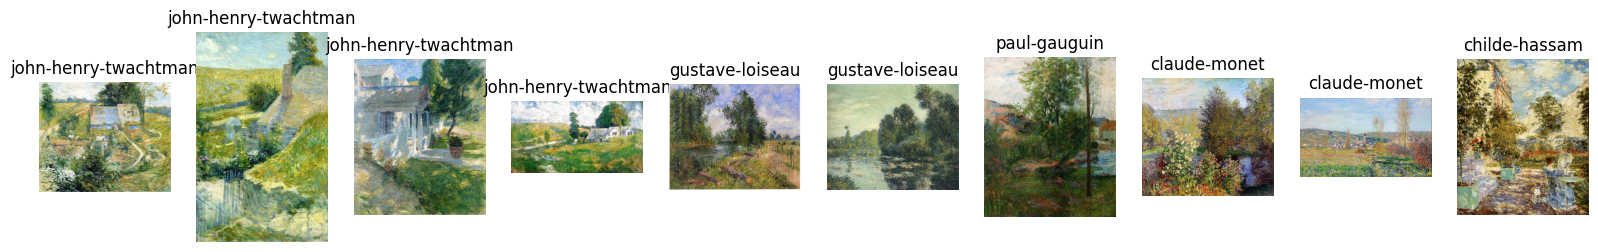

In [62]:
from matplotlib import pyplot as plt
from PIL import Image
def plot_examples(query, positive_indexes, df):
    plt.imshow(Image.open('wikiart/'+df.loc[query].relative_path))
    plt.title(str(df.loc[query].artist_name+ 'influencers:'+str(df.loc[query].influenced_by)))
    fig, axes = plt.subplots(1, 10, figsize=(20, 10))
    for i, ax in enumerate(axes):
        #ax.imshow(Image.open('wikiart/'+df.iloc[query].relative_path))
        image_path = 'wikiart/'+df.iloc[positive_indexes[i]].relative_path
        image =  Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(df.iloc[positive_indexes[i]].artist_name)

query = 999
plot_examples(query,df.loc[query,'index_vector_similarity'],df)

In [85]:
def get_dictionaries(df,num_examples):
    dict_influenced_by = df.groupby('artist_name')['influenced_by'].first().to_dict()
    artist_to_paintings = {}
    for index, row in df.iterrows():
        artist = row['artist_name']
        artist_to_paintings.setdefault(artist, []).append(index)
    artist_to_influencer_paintings = {artist: [painting for influencer in influencers if influencer in artist_to_paintings for painting in artist_to_paintings[influencer]] for artist, influencers in dict_influenced_by.items()}
    keys_min_val = [key for key, value in artist_to_influencer_paintings.items() if isinstance(value, list) and len(value) > num_examples]
    artist_to_influencer_paintings = {key: value for key, value in artist_to_influencer_paintings.items() if key in keys_min_val}
    artisit_no_influencers = [k for k, v in artist_to_influencer_paintings.items() if len(v) == 0]
    artist_to_influencer_paintings = {key: value for key, value in artist_to_influencer_paintings.items() if key not in artisit_no_influencers}
    artist_to_paintings_new = {key: value for key, value in artist_to_paintings.items() if key in artist_to_influencer_paintings.keys()}
    return artist_to_influencer_paintings, artist_to_paintings_new


import torch
import faiss


def vector_similarity_search_group(query_indexes, index_list, df, feature, device, num_examples):
    '''Search for similar vectors in the dataset using faiss library'''
    k = num_examples + 1


    index_list = [i for i in index_list if i < len(df)]
    if index_list != None:
        xb = torch.stack(df[feature].tolist())[index_list]
    else:
        xb = torch.stack(df[feature].tolist())


    d = xb.shape[1]
    index = faiss.IndexFlatL2(d)
    
    if device == 'cuda':
        index = faiss.index_cpu_to_all_gpus(index)
        
    index.train(xb.cpu().numpy() if device != 'cuda' else xb)
    index.add(xb.cpu().numpy() if device != 'cuda' else xb)
    results = []
    for query in query_indexes:
        query_vector = df[feature].tolist()[query]
        D, I = index.search(query_vector.reshape(1,-1), k)  
        I = list(I[0][1:])   
        I = [index_list[i] for i in I]
        #df[f'pos_ex_{self.feature}'].iloc[query] = I
        df.at[query,f'pos_ex_{feature}'] = I
        results.append(I)
        
        
    return df[f'pos_ex_{feature}']

import random
def positive_examples_group(df,feature,dict_influence_indexes,artist_to_paintings, device, similarity_based,num_examples):
    search_all = False
    grouped = df.groupby('artist_name')
    df[f'pos_ex_{feature}'] = [None]*len(df)
    for artist, group in grouped:
        query = list(group.index)
        query = [i for i in query if i < len(df)]
        if search_all:
            if artist in dict_influence_indexes:
                index_list = dict_influence_indexes[artist]
                index_list = [i for i in index_list if i < len(df)]
        else:
            if artist in artist_to_paintings:
                no_index_list = artist_to_paintings[artist]
                index_list = set(df.index) - set(no_index_list)
            #index_list = df[df.artist_name != df.iloc[query].artist_name].index
        if similarity_based == True:
            df[f'pos_ex_{feature}'] = vector_similarity_search_group(query, index_list, df, feature, device, num_examples)
            print(f'finished searching for {artist}')
        else:
            for q in query:
                df.at[q,f'pos_ex_{feature}'] = random.sample(index_list, num_examples)
    return df[f'pos_ex_{feature}']

dict_influence_indexes, artist_to_paintings = get_dictionaries(df,10)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
general_examples_group = positive_examples_group(df, 'image_features',dict_influence_indexes,artist_to_paintings,device,similarity_based=True, num_examples=10)




finished searching for adriaen-brouwer
finished searching for adriaen-van-ostade
finished searching for albrecht-durer
finished searching for alfred-sisley
finished searching for alphonse-mucha
finished searching for amedeo-modigliani
finished searching for anders-zorn
finished searching for andrea-mantegna
finished searching for andy-warhol
finished searching for anna-ostroumova-lebedeva
finished searching for annibale-carracci
finished searching for anthony-van-dyck
finished searching for arkhip-kuindzhi
finished searching for arshile-gorky
finished searching for aubrey-beardsley
finished searching for auguste-rodin
finished searching for bartolome-esteban-murillo
finished searching for berthe-morisot
finished searching for boris-kustodiev
finished searching for camille-corot
finished searching for camille-pissarro
finished searching for caravaggio
finished searching for chaim-soutine
finished searching for charles-francois-daubigny
finished searching for childe-hassam
finished searc

In [87]:
list_of_counts = []
for i in general_examples_group:
    artist_influenced = df.loc[i[0],'artist_name']
    influencers_paintings = artist_to_influencer_paintings[artist_influenced]
    #print(f'artist: {artist_influenced} has been influenced by {influencers_paintings}')
    count = 0    
    for j in i:
        if j in influencers_paintings:
            if j != i[0]:
                count += 1
                #print(f'for index {i[0]}: {j}')
    #print(f'count: {count}')            
    list_of_counts.append(count)
print(np.mean(list_of_counts))

0.2347910159155139


TRAINED MODELS

In [ ]:

from Triplet_Network import TripletResNet_features
import torch.nn as nn

model = TripletResNet_features(512)
model_path ='trained_models/triplet_network_featureswikiart_full_features_34.csv.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
#model = nn.Sequential(*list(model.children())[:-1]) 
#model.forward_once(df.extracted_features.iloc[query])
df['trained_features'] = df.extracted_features.apply(lambda x: model.forward_once(x).detach().numpy())